# <h1 align="center">explainable Artificial Intelligence</h1> 

<h3 align="left">Goal</h3> 

Our objective of this work is to study the plicability of a machine learning model. For this, we are going to create a model that allows us to recognize dogs and cats. We will then try to explain a prediction of this model using the *** LIME *** method.
<br><br>

<h3 align="left">What is the explainability of a machine learning model?</h3> 

AI is now a technology used by many industries and in areas that closely affect the individual such as education or health. It is essential that the various actors of society, citizens, businesses or regulators, can have confidence in the decisions it makes.

With applications such as facial recognition, self-driving cars, the predictions provided by AI have a huge impact on organizations using these technologies, and on the individuals who use them. Therefore, the need to understand these predictions is an undeniable prerequisite for building trust and sustaining adoption of AI. To be efficient and respond to increasingly precise issues, taking into account a multitude of variables of often different natures, AI algorithms have become sophisticated and reach such a level of complexity that they sometimes go beyond the understanding of users.

Thus, the processes allowing them to transform data into a prediction seem opaque, thus limiting our ability to understand why and how they lead to a decision. These algorithms are called "black boxes". Conversely, some "white box" algorithms, such as linear regressions, are systematically understandable but less efficient.

Explainability is the key to not having to choose between performance and confidence, it is about developing tools that can improve our understanding of black boxes, and turn them into gray boxes. That is to say algorithms, admittedly opaque, but whose decision-making processes are partially broken down and explained.

There are now implementations that can partially or fully explain black box models. Among these methods, we can mention LIME, SHARP, ICE, DPD ...


# references
- https://github.com/marcotcr/lime
- https://www.inovex.de/blog/lime-machine-learning-interpretability/
- https://lime-ml.readthedocs.io/en/latest/lime.html

# Data source

The data used for this work is available on kaggle in the link
 https://www.kaggle.com/salader/dogs-vs-cats

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from PIL import Image
import seaborn as sns
import time
from tempfile import mkdtemp
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation, Input, Concatenate, Layer
from keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_mobile_net_v2 = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model_mobile_net_v2.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


# Definition of constants (batch_size, image size, labels)

In [ ]:
labels = ['cats', 'dogs']
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_DEPTH = 3
EPOCH = 20

# Function to get data

In [ ]:
def get_images(path_image):
  list_images = []
  for label in labels:
    path_image_label = path_image + '/' + label
    fichiers = [f for f in os.listdir(path_image_label) if os.path.isfile(os.path.join(path_image_label, f))]
    for fichier in fichiers:
      try:
        img = cv.imread(path_image_label + '/' + fichier)
        im_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        resized_img = cv.resize(im_rgb, (IMG_WIDTH, IMG_HEIGHT))
        list_images.append([resized_img, labels.index(label)])
      except:
        print(fichier)

  return np.array(list_images)

# Loading train and test data

In [ ]:
train_data = get_images('/content/drive/My Drive/dogs_vs_cats/train')
test_data = get_images('/content/drive/My Drive/dogs_vs_cats/test')

In [ ]:
print('{} images in training set'.format(len(train_data)))
print('{} images in test set'.format(len(test_data)))

20000 images in training set
5000 images in test set


We will divide the training images into 2 parts:
- 75% for the train
- 25% for validation

In [ ]:
train_data, validation_data = train_test_split(train_data, test_size=0.25, random_state=42)

In [ ]:
print('{} images in training set'.format(len(train_data)))
print('{} images in validation set'.format(len(validation_data)))
print('{} images in test set'.format(len(test_data)))

15000 images in training set
5000 images in validation set
5000 images in test set


In [ ]:
print('{} images in training set'.format(len(train_data)))
print('--- {} CATS IMAGES IN TRAINING SET'.format([y for _, y in train_data].count(0)))
print('--- {} DOGS IMAGES IN TRAINING SET'.format([y for _, y in train_data].count(1)))

15000 images in training set
--- 7476 CATS IMAGES IN TRAINING SET
--- 7524 DOGS IMAGES IN TRAINING SET


In [ ]:
print('{} images in validation set'.format(len(validation_data)))
print('--- {} CATS IMAGES IN VALIDATION SET'.format([y for _, y in validation_data].count(0)))
print('--- {} DOGS IMAGES IN VALIDATION SET'.format([y for _, y in validation_data].count(1)))

5000 images in validation set
--- 2524 CATS IMAGES IN VALIDATION SET
--- 2476 DOGS IMAGES IN VALIDATION SET


In [ ]:
print('{} images in test set'.format(len(test_data)))
print('--- {} CATS IMAGES IN TEST SET'.format([y for _, y in test_data].count(0)))
print('--- {} DOGS IMAGES IN TEST SET'.format([y for _, y in test_data].count(1)))

5000 images in test set
--- 2500 CATS IMAGES IN TEST SET
--- 2500 DOGS IMAGES IN TEST SET


# Data Visualization and Preprocessing

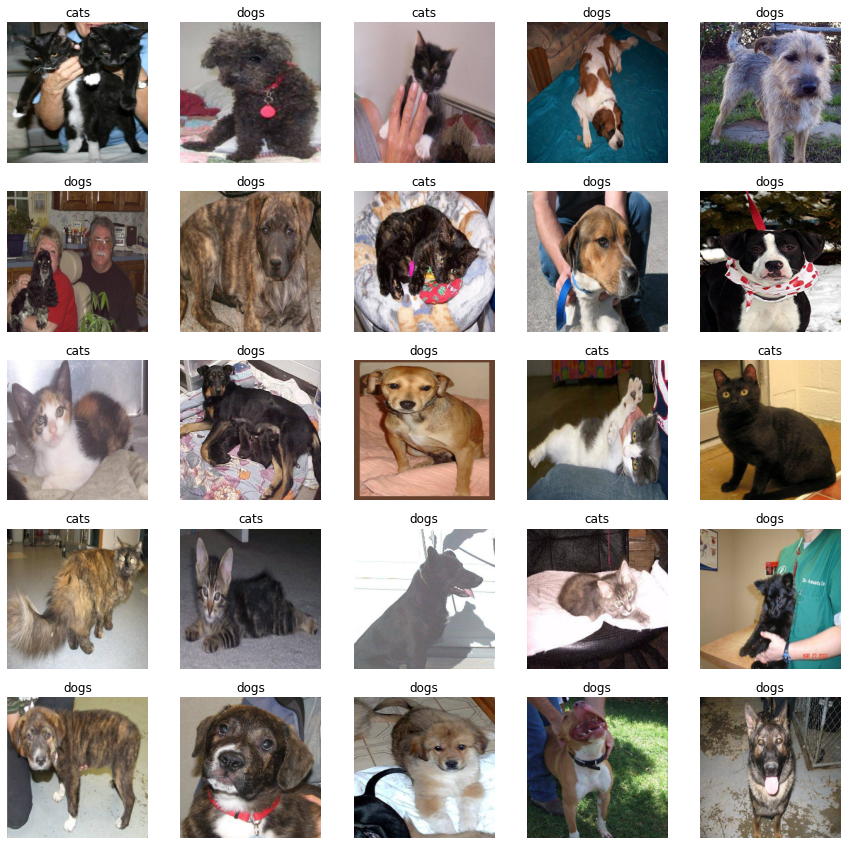

In [ ]:
plt.figure(figsize=(15, 15))
for k, i in np.ndenumerate(np.random.randint(train_data.shape[0], size=25)):
    ax = plt.subplot(5, 5, k[0] + 1)
    plt.imshow(train_data[i][0], cmap='gray')
    plt.title(labels[train_data[i][1]])
    plt.axis("off")

# Process the data

In [ ]:
def prepare_data(data):
    x = []
    y = []
    
    for feature, label in data:
      x.append(feature)
      y.append(label)

    x = np.array(x)
    y = np.array(y)
        
    return x, y

In [ ]:
x_train_int, y_train = prepare_data(train_data)
x_val_int, y_val = prepare_data(validation_data)
x_test_int, y_test = prepare_data(test_data)

For reasons of memory availability, we must create 3 memory spaces to arrays stored in a binary file on the disk, corresponding to the training, validation and test data.

In [ ]:
filename_train = os.path.join(mkdtemp(), 'newfile_train.dat')
x_train = np.memmap(filename_train, dtype='float32', mode='w+', shape=x_train_int.shape)

filename_val = os.path.join(mkdtemp(), 'newfile_val.dat')
x_val = np.memmap(filename_val, dtype='float32', mode='w+', shape=x_val_int.shape)

filename_test = os.path.join(mkdtemp(), 'newfile_test.dat')
x_test= np.memmap(filename_test, dtype='float32', mode='w+', shape=x_test_int.shape)

In [ ]:
x_train[:] = x_train_int[:]
x_val[:] = x_val_int[:]
x_test[:] = x_test_int[:]

We divide the pixels of each image by 255

In [ ]:
for i in range(x_train.shape[0]):
  x_train[i] = x_train[i] / 255

for i in range(x_val.shape[0]):
  x_val[i] = x_val[i] / 255

for i in range(x_test.shape[0]):
  x_test[i] = x_test[i] / 255

In [ ]:
print('The new shape of images is {}'.format(x_train[0].shape))
print('Number of images train is {}'.format(x_train.shape[0]))

The new shape of images is (224, 224, 3)
Number of images train is 15000


# Process Data augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range = 20, 
    zoom_range = 0.2, 
    width_shift_range=0.15,  
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip = True,  
    vertical_flip=True,
    fill_mode="nearest")

# Build the model

In [ ]:
model = tf.keras.models.Sequential([
    model_mobile_net_v2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2623488   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 7,504,961
Trainable params: 5,246,977
Non-trainable params: 2,257,984
______________________________________

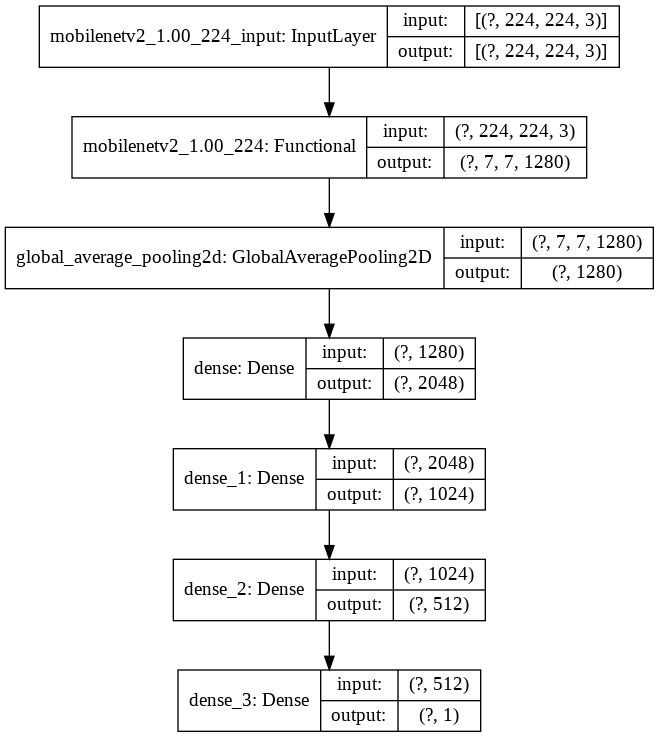

In [ ]:
plot_model(model, 'model2.png', show_shapes=True)

# Compile the model

In [ ]:
opt = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-4 / EPOCH)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size = BATCH_SIZE) ,epochs = EPOCH , validation_data = (x_val, y_val),
                    steps_per_epoch=len(x_train) // BATCH_SIZE)

Epoch 1/20
468/468 [==============================] - 460s 982ms/step - loss: 0.1829 - precision: 0.9262 - recall: 0.9263 - val_loss: 0.0698 - val_precision: 0.9662 - val_recall: 0.9826
Epoch 2/20
468/468 [==============================] - 472s 1s/step - loss: 0.1410 - precision: 0.9441 - recall: 0.9436 - val_loss: 0.0631 - val_precision: 0.9630 - val_recall: 0.9871
Epoch 3/20
468/468 [==============================] - 473s 1s/step - loss: 0.1313 - precision: 0.9480 - recall: 0.9470 - val_loss: 0.0711 - val_precision: 0.9560 - val_recall: 0.9915
Epoch 4/20
468/468 [==============================] - 473s 1s/step - loss: 0.1196 - precision: 0.9522 - recall: 0.9498 - val_loss: 0.0685 - val_precision: 0.9589 - val_recall: 0.9887
Epoch 5/20
468/468 [==============================] - 473s 1s/step - loss: 0.1139 - precision: 0.9553 - recall: 0.9544 - val_loss: 0.0594 - val_precision: 0.9747 - val_recall: 0.9786
Epoch 6/20
468/468 [==============================] - 474s 1s/step - loss: 0.1075 

In [ ]:
evaluate = model.evaluate(x_test,y_test, verbose=0)
print("Loss of the model is - " , evaluate[0])
print("Precision of the model is - " , evaluate[1]*100 , "%")
print("Recall of the model is - " , evaluate[2]*100 , "%")

Loss of the model is -  0.07024922221899033
Precision of the model is -  97.74168133735657 %
Recall of the model is -  98.68000149726868 %


# Analysis after Model Training

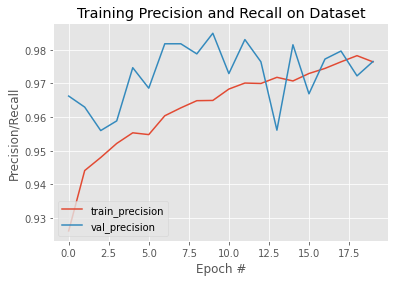

In [ ]:
# plot the training loss and accuracy
N = EPOCH
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history['precision'], label="train_precision")
plt.plot(np.arange(0, N), history.history['val_precision'], label="val_precision")
plt.title("Training Precision and Recall on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Precision/Recall")
plt.legend(loc="lower left")
plt.savefig("plot.png")

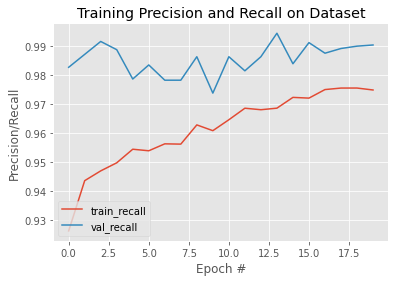

In [ ]:
# plot the training loss and accuracy
N = EPOCH
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history['recall'], label="train_recall")
plt.plot(np.arange(0, N), history.history['val_recall'], label="val_recall")
plt.title("Training Precision and Recall on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Precision/Recall")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
predictions = np.array(tf.greater(model.predict(x_test), .5))
predictions = predictions.reshape(1,-1)[0]
predictions = np.array([0 if i == False else True for i in predictions])
predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Cats (Class 0)','Dogs (Class 1)']))

                precision    recall  f1-score   support

Cats (Class 0)       0.99      0.98      0.98      2500
Dogs (Class 1)       0.98      0.99      0.98      2500

      accuracy                           0.98      5000
     macro avg       0.98      0.98      0.98      5000
  weighted avg       0.98      0.98      0.98      5000



In [ ]:
cm = confusion_matrix(y_test, predictions)
cm

array([[2443,   57],
       [  33, 2467]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

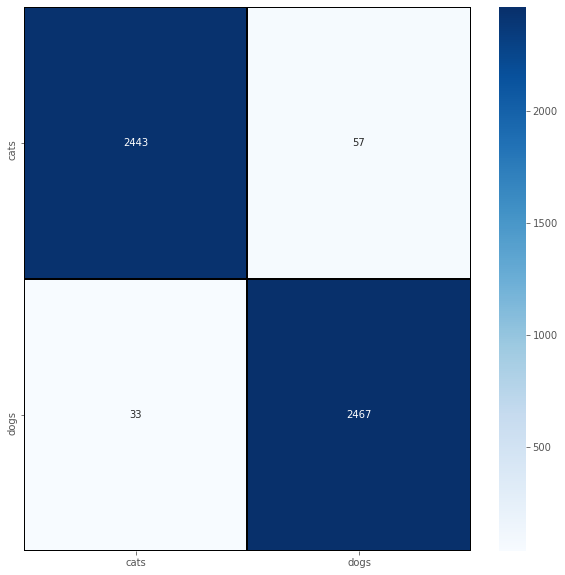

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]  

### Some of the Correctly Predicted Classes

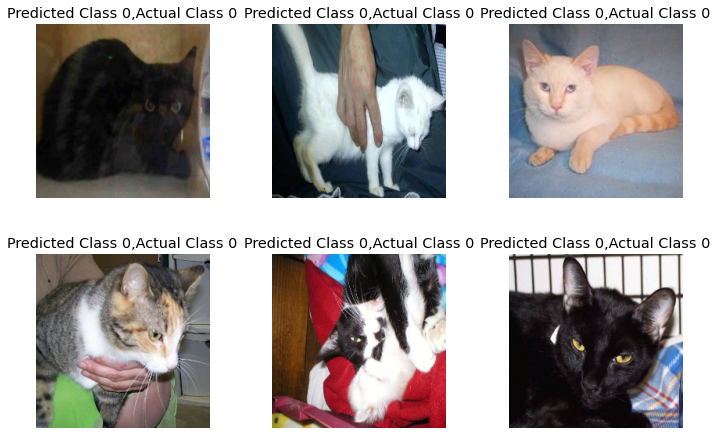

In [ ]:
i = 0
plt.figure(figsize = (10,10))
for c in correct[:6]:
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c])
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

###Some of the Incorrectly Predicted Classes

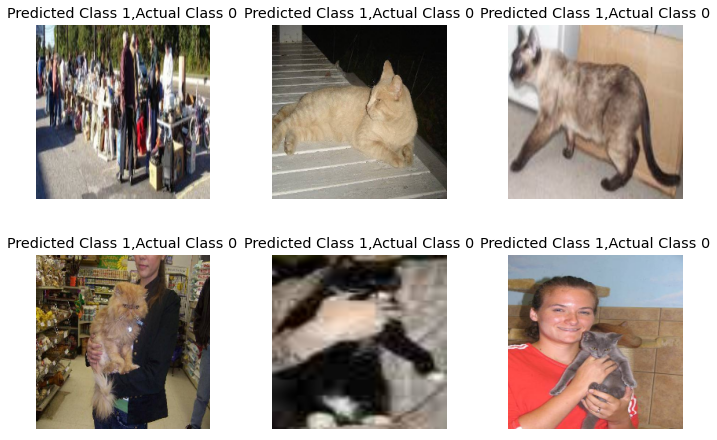

In [ ]:
i = 0
plt.figure(figsize = (10,10))
for c in incorrect[:6]:
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c])
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Explainable

Now we will analyze a prediction with the LIME method. We will start by importing the necessary libraries

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    !pip install lime
    import lime
from lime import lime_image
from keras.preprocessing import image
from skimage.segmentation import mark_boundaries

     |████████████████████████████████| 276kB 4.3MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=13129593ca2687873c99f2036c6865f727cf17d9afa026f785aed17e57f0cc99
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255
        out.append(x)
    return np.vstack(out)

##### We import an image

In [85]:
images = transform_img_fn(['/content/drive/My Drive/dogs_vs_cats/test/dogs/dog.10014.jpg'])
images.shape

(1, 224, 224, 3)


La classe prédite est dogs



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  """


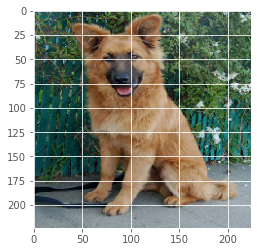

In [86]:
plt.imshow(np.array(images[0]))
preds = np.array(tf.greater(model.predict(images), .5))
preds = np.array([0 if i == False else True for i in preds])
print()
print('La classe prédite est {}'.format(labels[preds[0]]))
print()

Our model is quite sure that there is a fox dog in the picture. Quite impressive!

Now that we have observed the result of our complex classifier, let's apply LIME to identify the parts of the image that have the most influence on the dog's prediction. To do this, we feed an explanation with the image of the dog and provide it with the number of patches to be determined (num_features) as well as the number of disturbances of the interpretable representation (num_samples):

In [87]:
explainer = lime_image.LimeImageExplainer()

In [88]:
images[0].shape

(224, 224, 3)

In [89]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_features=20, num_samples=500)


CPU times: user 4.7 s, sys: 348 ms, total: 5.04 s
Wall time: 4.99 s


Let's see which parts of the image contributed the most to the squirrel prediction:

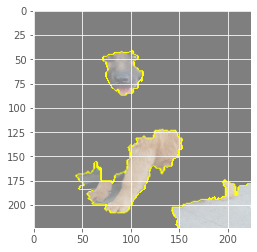

In [90]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

It was the dog's face and his paw. Both, quite reasonable causes for the prediction of the road. Good game!

Now let's look at this with the whole image


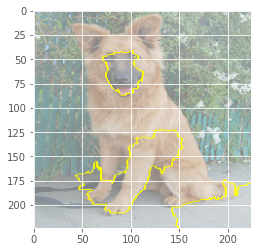

In [91]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

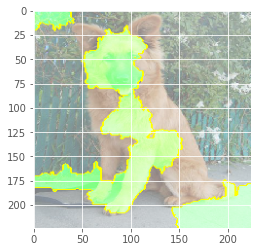

In [92]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Let's find the most important weights that made it possible to obtain this prediction. For this, we will display the pixels that have a minimum weight of 0.1


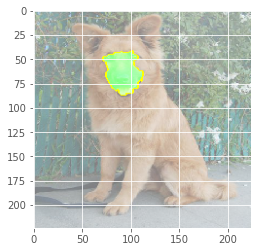

In [93]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

As we can see, it was the mouth of the dog that made the prediction

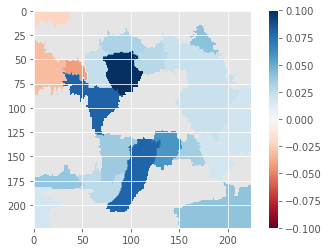

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()